# Result reproduction

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

#np.random.seed(32)

from MyDataset import IndianPines, PaviaUniversity, PaviaCenter
from SSGA import SSGA

In [78]:
#usedDataset = IndianPines
usedDataset = PaviaUniversity
#usedDataset = PaviaCenter

610 340 103
31


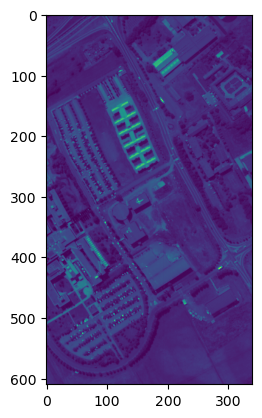

In [79]:
n,m,B = usedDataset["shape"]
print(n,m,B)
b = np.random.randint(0, B-1)
print(b)
plt.imshow(usedDataset["data"][:,:,b])
plt.show()

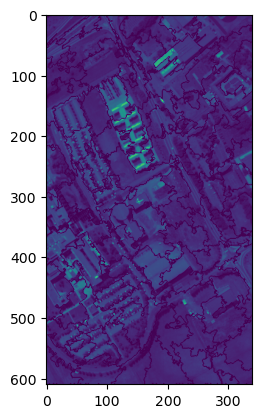

In [ ]:
from EntropyRateSuperpixel import find_superpixel, complete_basic_similarity, plot_img_with_borders

K = 300
SP = find_superpixel(usedDataset["data"], K, 0.5*8, complete_basic_similarity, True)
plot_img_with_borders(usedDataset["data"][:,:,b], SP)
plt.show()

0.23286613370882384
0.24925582268971966
0.270901287782491
0.23587140456668287
0.23765718744848568
0.2464519616908654
0.23984143040755582
0.2719993088557602
0.24702550534797316
0.2610577803229835


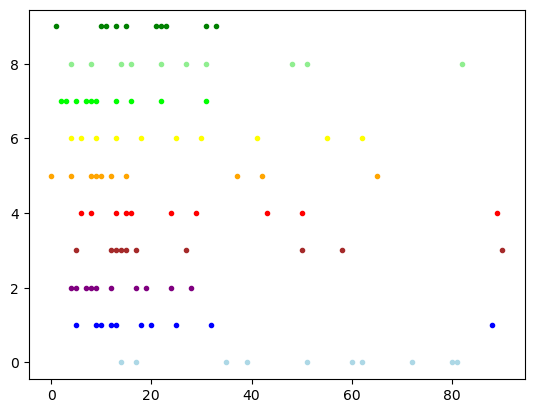

In [81]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

N = 10
colors = ["lightblue", "blue", "purple", "brown", "red", "orange", "yellow", "lime", "lightgreen", "green"]
best_indiv = None
best_fitness = 0
for j in range(N):
    pop, fitness = SSGA(usedDataset["data"], 10, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SP)
    if fitness[0]>best_fitness:
        best_indiv = pop[0]
        best_fitness = fitness[0]
    print(fitness[0])
    for i,b in enumerate(pop[0]):
        if b==1:
            plt.plot(i,j, ".", color=colors[j])
plt.show()

# Select samples

In [83]:
import sklearn.utils

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1
            weights[key] = nb_info/ len(liste)
            print(key, name, int(len(liste)*percent), len(liste), len(liste)/nb_info)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    

best_paper_indiv = [0 for _ in range(B)]
indian_best_index = [16, 28, 31, 38, 71, 83, 113, 128, 162]
university_best_index = [18, 33, 47, 64, 69, 72, 67, 83, 85]
center_best_index = [16, 37, 44, 66, 74, 83, 85, 97, 101]
for i in university_best_index:
    best_paper_indiv[i] = 1

from SSGA import fitness_function, compute_Sbsp_Stsp_list
#Sbsp_list, Stsp_list = compute_Sbsp_Stsp_list(usedDataset["data"], SP)
#print(fitness_function(best_paper_indiv, Sbsp_list, Stsp_list))



bands=best_indiv
#bands=best_paper_indiv
#bands=[1 for _ in range(B)]
X_train,y_train, X_test,y_test, weights = split_data(usedDataset, 0.05, bands)
print(X_train.shape, X_test.shape)
print(weights)

1 Asphalt 331 6631 0.1550168318683374
2 Meadows 932 18649 0.4359687675331962
3 Gravel 104 2099 0.049069571722461194
4 Trees 153 3064 0.0716289508135403
5 Painted metal sheets 67 1345 0.03144286515803254
6 Bare Soil 251 5029 0.11756592481765477
7 Bitumen 66 1330 0.03109220123433701
8 Self-Blocking Bricks 184 3682 0.08607630446979615
9 Shadows 47 947 0.022138582382644472
(2135, 10) (40641, 10)
{1: 6.450912381239632, 2: 2.2937422918118933, 3: 20.37922820390662, 4: 13.96083550913838, 5: 31.803717472118958, 6: 8.505865977331478, 7: 32.1624060150376, 8: 11.617599130907116, 9: 45.17001055966209}


# Sklearn SVM

In [84]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf'))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001],

    #'svc__C': [10, 50, 75, 100, 150],
    #'svc__gamma': [1, 0.75, 0.5, 0.25, 0.01]
}

clf = svm.SVC(kernel="rbf", C=1.0, gamma="scale")#, class_weight="balanced")
#clf = svm.SVC(kernel="rbf", C=2**32, gamma=3.0517578125e-05)#, class_weight="balanced")
clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_pred.tolist())
print("Accuracy =", len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]])/len(y_pred))

print(clf.get_params())
print(clf.best_estimator_.get_params())

[4, 2, 2, 1, 8, 2, 2, 2, 2, 1, 2, 6, 5, 3, 6, 6, 6, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 4, 8, 1, 1, 5, 2, 2, 2, 2, 9, 6, 1, 5, 1, 6, 2, 4, 2, 2, 3, 6, 6, 2, 2, 8, 1, 6, 8, 8, 2, 2, 2, 2, 2, 2, 1, 2, 2, 5, 4, 5, 6, 2, 2, 2, 1, 2, 1, 8, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 8, 6, 2, 2, 4, 1, 2, 2, 2, 2, 6, 2, 2, 2, 6, 1, 1, 1, 6, 2, 5, 6, 8, 2, 2, 2, 2, 5, 6, 2, 8, 8, 1, 2, 7, 4, 4, 1, 2, 2, 2, 1, 1, 3, 6, 3, 2, 2, 2, 2, 2, 2, 2, 5, 2, 1, 3, 2, 2, 2, 4, 2, 4, 6, 7, 6, 6, 2, 2, 6, 6, 1, 2, 8, 9, 2, 4, 1, 4, 1, 2, 6, 3, 8, 6, 2, 6, 6, 7, 2, 6, 2, 1, 9, 2, 2, 2, 4, 1, 2, 9, 6, 1, 6, 2, 6, 1, 1, 5, 2, 2, 2, 8, 2, 2, 2, 6, 1, 2, 2, 2, 7, 6, 6, 6, 1, 6, 5, 1, 1, 2, 6, 1, 2, 1, 6, 6, 5, 2, 8, 6, 6, 1, 2, 1, 2, 2, 2, 8, 1, 2, 2, 6, 1, 2, 1, 4, 8, 2, 2, 2, 5, 2, 2, 8, 8, 2, 8, 2, 2, 2, 1, 8, 3, 2, 6, 2, 2, 2, 8, 2, 2, 8, 6, 2, 1, 9, 5, 8, 8, 1, 2, 2, 2, 2, 8, 8, 2, 8, 6, 2, 2, 4, 4, 7, 2, 1, 3, 8, 8, 4, 1, 2, 6, 1, 9, 8, 6, 2, 2, 1, 2, 2, 8, 4, 3, 6, 5, 1, 6, 4, 1, 2, 2, 2, 6, 8, 2, 6, 2, 1, 2, 2, 2, 2, 

# LibSVM1 toolbox

https://www.csie.ntu.edu.tw/~cjlin/libsvm/

In [85]:
from libsvm.svmutil import svm_train, svm_predict, svm_parameter, svm_problem
from sklearn.model_selection import KFold

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Prepare cross-validation splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameters grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        accuracies = []
        for train_index, val_index in kf.split(X_scaled):
            X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
            y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

            # Create libsvm problem
            prob = svm_problem(y_train_cv.tolist(), X_train_cv.tolist())

            # Setup parameters string for libsvm
            param_str = f'-s 0 -t 2 -c {C} -g {gamma} -q'  
            # -s 0: C-SVC, -t 2: RBF kernel, -c: C, -g: gamma, -q: quiet mode

            param = svm_parameter(param_str)

            # Train model
            model = svm_train(prob, param)

            # Predict on validation fold
            p_label, p_acc, p_val = svm_predict(y_val_cv.tolist(), X_val_cv.tolist(), model, options='-q')

            accuracies.append(p_acc[0])  # p_acc is [accuracy, mean squared error, squared correlation]

        avg_acc = np.mean(accuracies)
        print(f"C={C}, gamma={gamma}, CV accuracy={avg_acc:.4f}")

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = {'C': C, 'gamma': gamma}

print(f"Best CV accuracy: {best_score:.4f} with params {best_params}")


C=0.1, gamma=1, CV accuracy=70.1639
C=0.1, gamma=0.1, CV accuracy=61.5925
C=0.1, gamma=0.01, CV accuracy=58.8759
C=0.1, gamma=0.001, CV accuracy=46.0422
C=1, gamma=1, CV accuracy=80.2342
C=1, gamma=0.1, CV accuracy=71.9906
C=1, gamma=0.01, CV accuracy=61.5457
C=1, gamma=0.001, CV accuracy=58.8759
C=10, gamma=1, CV accuracy=81.9672
C=10, gamma=0.1, CV accuracy=80.0937
C=10, gamma=0.01, CV accuracy=72.6464
C=10, gamma=0.001, CV accuracy=61.6862
C=100, gamma=1, CV accuracy=81.8267
C=100, gamma=0.1, CV accuracy=82.9977
C=100, gamma=0.01, CV accuracy=80.0000
C=100, gamma=0.001, CV accuracy=70.2576
Best CV accuracy: 82.9977 with params {'C': 100, 'gamma': 0.1}


In [86]:
from libsvm.svmutil import *
from libsvm.svm import *


prob = svm_problem(y_train, X_train)

# "parameters C and gamma were optimized by fivefold cross-validation"

param = svm_parameter()
param.kernel_type = 2 #RBF  # Radial Basis Function kernel
param.C = 2**0.1 #best_params["C"]  # Cost parameter
param.gamma = 1/(n*m * X_train.var()) #best_params["gamma"]  # Kernel parameter

#param.nr_weight = len(weights.keys())
#param.weight_label = (c_double * len(weights))(*list(weights.keys()))
#param.weight = (c_double * len(weights))(*list(weights.keys()))


# 5-fold cross-validation
param.cross_validation = True
param.nr_fold = 5
accuracy = svm_train(prob, param)

# Train model
param.cross_validation = False
model = svm_train(prob, param)
p_labels, p_acc, p_vals = svm_predict(y_test, X_test, model)  
print(p_labels)
print(p_acc)

*
optimization finished, #iter = 123
nu = 0.634021
obj = -263.146420, rho = 0.993979
nSV = 246, nBSV = 246
*
optimization finished, #iter = 123
nu = 0.907749
obj = -262.560503, rho = 0.987563
nSV = 246, nBSV = 246
*
optimization finished, #iter = 123
nu = 0.759259
obj = -263.587510, rho = 0.998377
nSV = 246, nBSV = 246
*
optimization finished, #iter = 123
nu = 0.283084
obj = -263.652871, rho = 0.999762
nSV = 246, nBSV = 246
*
optimization finished, #iter = 53
nu = 0.602273
obj = -113.466985, rho = -0.996915
nSV = 106, nBSV = 106
*
optimization finished, #iter = 38
nu = 0.472050
obj = -81.453206, rho = -0.999853
nSV = 76, nBSV = 76
*
optimization finished, #iter = 84
nu = 0.811594
obj = -179.527898, rho = -0.992741
nSV = 168, nBSV = 168
*
optimization finished, #iter = 54
nu = 0.610169
obj = -112.041605, rho = -0.928416
nSV = 108, nBSV = 108
*
optimization finished, #iter = 148
nu = 0.716707
obj = -317.243312, rho = -1.004564
nSV = 296, nBSV = 296
*
optimization finished, #iter = 206
nu

In [87]:
def save_libsmv_data(path, X_train, y_train):
    f = open(path, "w")
    for i in range(len(y_train)):
        txt = str(y_train[i])
        for j in range(len(X_train[i])):
            txt += " " + str(j+1) + ":" + str(X_train[i,j])
        f.write(txt + "\n")
    f.close()

save_libsmv_data("libsvm_train_data.txt", X_train, y_train)
save_libsmv_data("libsvm_test_data.txt", X_test, y_test)

In [88]:
y_train_libsvm, X_train_svm = svm_read_problem('libsvm_train_data.txt')
y_test_libsvm, X_test_libsvm = svm_read_problem("libsvm_test_data.txt")
# Train the model (C-SVC with RBF kernel by default)
c=32.0
g=3.0517578125e-05
print('-c {} -g {}'.format(c,g))
model = svm_train(y_train_libsvm, X_train_svm, '-c {} -g {} '.format(c,g))

# Predict using the same training data (or test data)
p_label, p_acc, p_val = svm_predict(y_test_libsvm, X_test_libsvm, model)
print(p_label)

-c 32.0 -g 3.0517578125e-05
*
optimization finished, #iter = 153
nu = 0.632231
obj = -9742.304199, rho = 0.984420
nSV = 306, nBSV = 306
*
optimization finished, #iter = 153
nu = 0.908012
obj = -9684.586792, rho = 0.967762
nSV = 306, nBSV = 306
*
optimization finished, #iter = 153
nu = 0.757426
obj = -9785.090454, rho = 0.995693
nSV = 306, nBSV = 306
*
optimization finished, #iter = 153
nu = 0.282028
obj = -9791.659302, rho = 0.999374
nSV = 306, nBSV = 306
*
optimization finished, #iter = 66
nu = 0.602740
obj = -4210.208069, rho = -0.992182
nSV = 132, nBSV = 132
*
optimization finished, #iter = 47
nu = 0.470000
obj = -3007.861694, rho = -0.999647
nSV = 94, nBSV = 94
*
optimization finished, #iter = 105
nu = 0.809339
obj = -6607.135376, rho = -0.982040
nSV = 208, nBSV = 208
*
optimization finished, #iter = 68
nu = 0.609091
obj = -3929.699280, rho = -0.814684
nSV = 134, nBSV = 134
*
optimization finished, #iter = 184
nu = 0.714563
obj = -11775.849060, rho = -1.010493
nSV = 368, nBSV = 368